In [61]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

In [62]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))
        
        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs


In [63]:
from transformers import SegformerImageProcessor

my_root_dir = "content/ADE20k_toy_dataset"
my_image_processor = SegformerImageProcessor(do_reduce_labels=True) #changed reduce_labels to do_reduce_labels

train_dataset = SemanticSegmentationDataset(root_dir=my_root_dir, image_processor=my_image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=my_root_dir, image_processor=my_image_processor, train=False)

In [64]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))


Number of training examples: 10
Number of validation examples: 10


In [65]:
my_encoded_inputs= train_dataset[0]

In [66]:
my_encoded_inputs["pixel_values"].shape


torch.Size([3, 512, 512])

In [67]:
my_encoded_inputs["labels"].shape


torch.Size([512, 512])

In [68]:
my_encoded_inputs["labels"]


tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [69]:
my_encoded_inputs["labels"].squeeze().unique() #to see unique ids of labels in an image

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

In [70]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)


In [71]:
batch = next(iter(train_dataloader))


In [72]:
for k2,v2 in batch.items():
  print(k2, v2.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [73]:
batch["labels"].shape


torch.Size([2, 512, 512])

In [74]:
mask = (batch["labels"] != 255)
mask


tensor([[[ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[False, False, False,  ...,  True,  True,  True],
         [False,  True,  True,  ...,  True,  True,  True],
         [False,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True,  True]]])

In [75]:
batch["labels"][mask]


tensor([5, 5, 5,  ..., 0, 0, 0])

In [76]:
#defining the model and labels. 

from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
import evaluate
metric = evaluate.load("mean_iou")


In [78]:
#I didn't touch the model. I mean it's a toy data set, obviously. I just wanted to see if it was working, and it did.

import torch
from torch import nn
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(2):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx2, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx2 % 1 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          
          #changed it to compute.
            metrics = metric.compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
            )
            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 5.08119010925293
Mean_iou: 3.2141680294393573e-06
Mean accuracy: 4.256056704145603e-05
Loss: 4.962482452392578
Mean_iou: 0.0005402128335739839
Mean accuracy: 0.020622515019376654
Loss: 5.010180950164795
Mean_iou: 0.0014357403354572178
Mean accuracy: 0.019127269029778488
Loss: 5.015254974365234
Mean_iou: 0.0002642229462526832
Mean accuracy: 0.010625695313073398
Loss: 4.952278137207031
Mean_iou: 0.0004677093938217764
Mean accuracy: 0.003389302793383471
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.964344024658203
Mean_iou: 0.0005928278269969281
Mean accuracy: 0.007416650326805813
Loss: 4.944246292114258
Mean_iou: 0.003121028257285044
Mean accuracy: 0.039619768771786856
Loss: 4.85670280456543
Mean_iou: 0.0021595333993680646
Mean accuracy: 0.01667492982418422
Loss: 4.639965057373047
Mean_iou: 0.011482080378681892
Mean accuracy: 0.10554900043630511
Loss: 4.78023099899292
Mean_iou: 0.004112726905496611
Mean accuracy: 0.07401234561429168


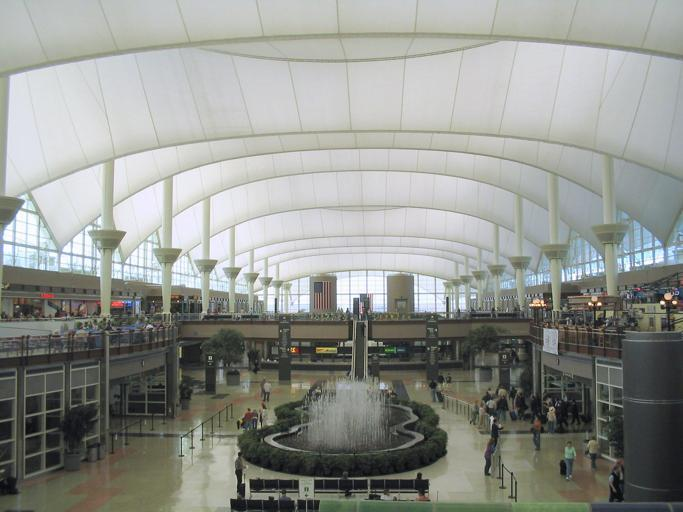

In [79]:
#inference
firstImage = Image.open('content/ADE20k_toy_dataset/images/training/ADE_train_00000001.jpg')
firstImage

In [80]:
# prepare the image for the model
pixel_values = my_image_processor(firstImage, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)


torch.Size([1, 3, 512, 512])


In [81]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)


In [82]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [83]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]


In [84]:
predicted_segmentation_map = my_image_processor.post_process_semantic_segmentation(outputs, target_sizes=[firstImage.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)


[[86 86 86 ... 46 46 46]
 [86 86 86 ... 46 46 46]
 [86 86 86 ...  5  5  5]
 ...
 [43 43 43 ... 97 97 97]
 [43 43 43 ... 97 97 97]
 [43 43 43 ... 97 97 97]]


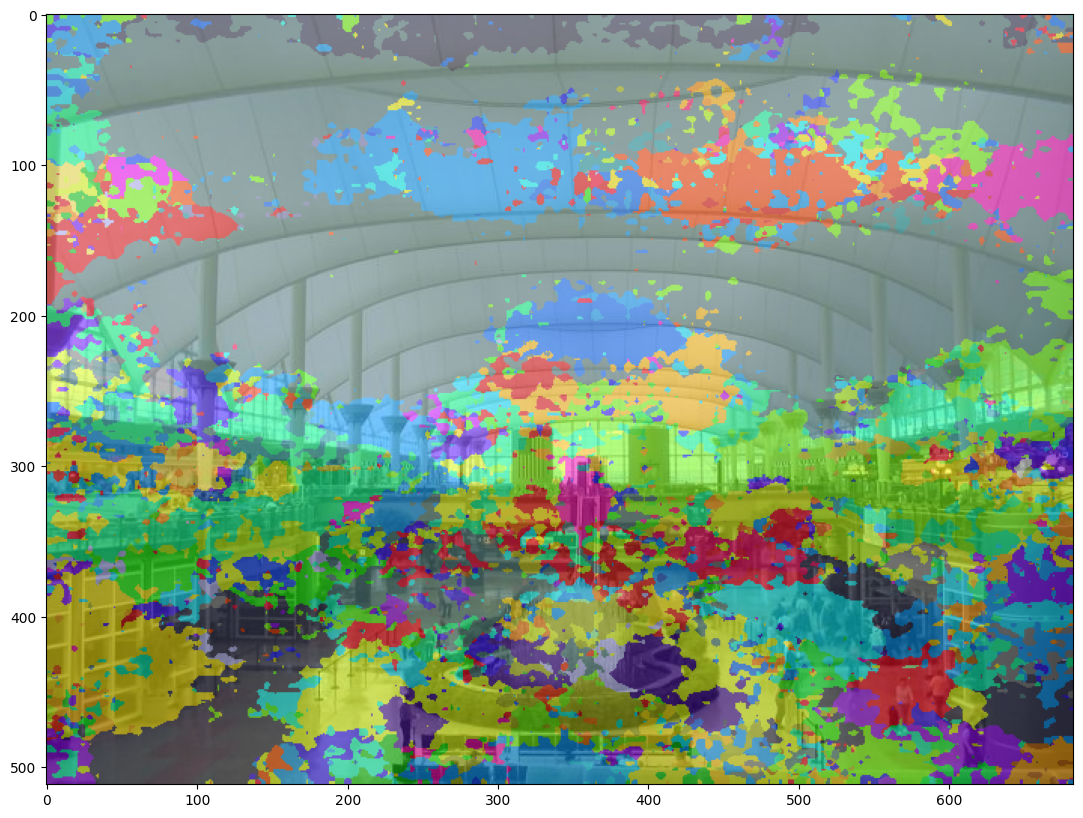

In [85]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(firstImage) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()


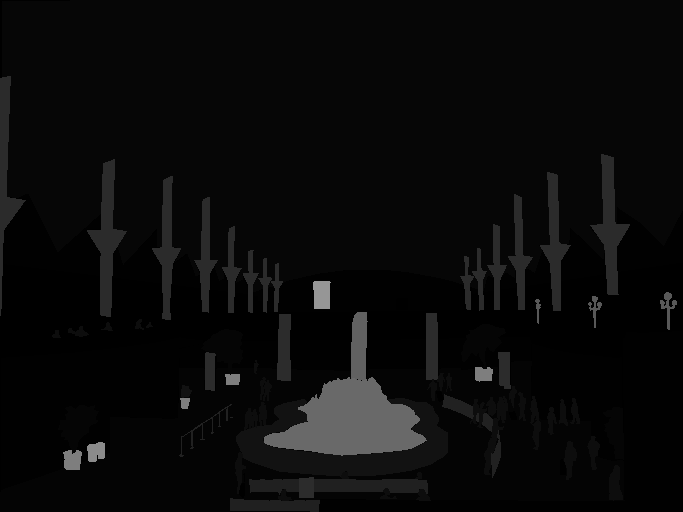

In [86]:
firstAnnotation = Image.open('content/ADE20k_toy_dataset/annotations/training/ADE_train_00000001.png')
firstAnnotation


Classes in this image: ['wall', 'floor', 'tree', 'ceiling', 'person', 'plant', 'seat', 'fence', 'column', 'signboard', 'streetlight', 'escalator', 'fountain', 'pot', 'ashcan', 'flag', None]


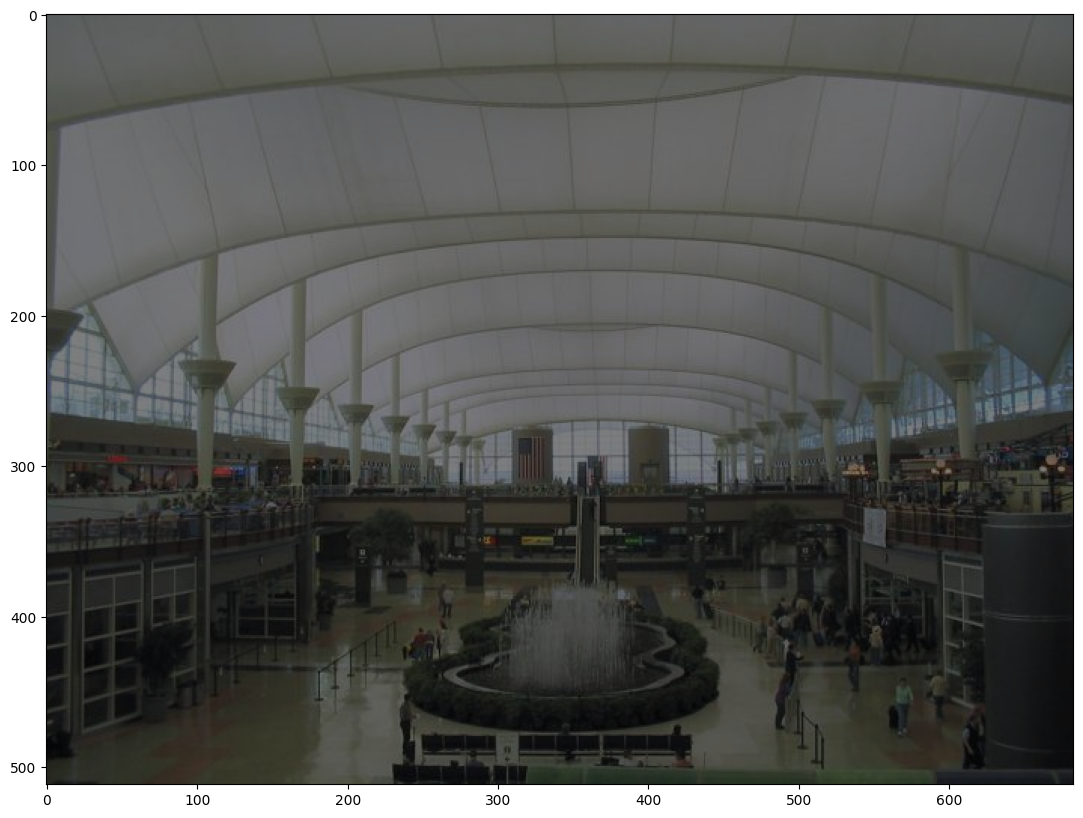

In [87]:
# convert map to NumPy array
firstAnnotation = np.array(firstAnnotation)
firstAnnotation[firstAnnotation == 0] = 255 # background class is replaced by ignore_index
firstAnnotation = firstAnnotation - 1 # other classes are reduced by one
firstAnnotation[firstAnnotation == 254] = 255

classes_map = np.unique(firstAnnotation).tolist()
unique_classes = [model.config.id2label[idx2] if idx2!=255 else None for idx2 in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((firstAnnotation.shape[0], firstAnnotation.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(firstImage) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()


In [88]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric.compute(
                  predictions=[predicted_segmentation_map],
                  references=[firstAnnotation],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )


In [89]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [90]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for my_id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][my_id],
                           metrics["per_category_accuracy"][my_id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])


mean_iou 0.008151592852622104
mean_accuracy 0.07706879407246747
overall_accuracy 0.35377725053842907
---------------------
per-category metrics:


,IoU,accuracy
wall,0.038008,0.038157
building,0.000000,NaN
sky,0.000000,NaN
floor,0.155753,0.205806
tree,0.000000,0.000000
...,...,...
shower,0.000000,NaN
radiator,0.000000,NaN
glass,0.000000,NaN
clock,0.000000,NaN
